## Impact of demographic factors on the global water withdrawal

In this experiment the influence of the population of a country regarding the total water withdrawal is analyzed.

The population should exerts a significant influence on water withdrawal due to its direct correlation with the demand for water resources. As the global population continues to grow, there is a subsequent increase in the need for water to sustain various human activities, including agriculture, industry, and domestic consumption. This rising demand places additional stress on water sources, leading to higher withdrawal rates.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

save_figs = True

### Import FAO Aquastat Data ###
----------------------------------------------------------
Source: FAO - Aquastat

Timespan: 1964 to 2020

Countries: 200+

Variables: 180+

----------------------------------------------------------
 
First we import water consumption and population data for each country from the aquastat dataset. The columns are rearranged by using the pivot function.

In [2]:
from src.utils import get_dataframe, to_fig_path

FILE_NAME = '../dat/fao_aquastat.csv'
CSV_URL = 'https://yaon.org/data.csv'

'''
Import CSV. This also downloads the file if it is not already present.
'''
import_df = get_dataframe(file_path=FILE_NAME, url=CSV_URL)
if import_df is None:
    print('Could not import CSV')
    exit(1)

'''Drop first column'''
import_df.drop(columns=['Unnamed: 0'], inplace=True)

'''Format dataframe'''
df = import_df.pivot_table(index=['Country', 'Year'], columns='Variable', values='Value', aggfunc='first')
df.reset_index(inplace=True)

df.head()

/Users/josef/Sync/Dokumente/SCHULE/Master/UT/Vorlesungen/Sem2/Data_Literacy/Paper/src/../dat/../dat/fao_aquastat.csv already exists.


Variable,Country,Year,% of agricultural GVA produced by irrigated agriculture,% of agricultural water managed area equipped for irrigation,% of area equipped for full control irrigation actually irrigated,% of area equipped for irrigation by desalinated water,% of area equipped for irrigation by direct use of treated municipal wastewater,% of area equipped for irrigation by direct use of agricultural drainage water,% of area equipped for irrigation by direct use of non-treated municipal wastewater,% of area equipped for irrigation by groundwater,...,Total water withdrawal,Total water withdrawal per capita,Treated municipal wastewater,Treated municipal wastewater discharged (secondary water),Urban population,Urban population with access to safe drinking-water (JMP),Water resources: total external renewable,Water withdrawal for aquaculture,Water withdrawal for cooling of thermoelectric plants,Water withdrawal for livestock (watering and cleaning)
0,Afghanistan,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,932.865,NaN,18.18,NaN,NaN,NaN
1,Afghanistan,1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,984.350,NaN,18.18,NaN,NaN,NaN
2,Afghanistan,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1038.852,NaN,18.18,NaN,NaN,NaN
3,Afghanistan,1967,NaN,100.0,NaN,NaN,NaN,NaN,NaN,15.399632,...,NaN,NaN,NaN,NaN,1096.428,NaN,18.18,NaN,NaN,NaN
4,Afghanistan,1968,NaN,100.0,NaN,NaN,NaN,NaN,NaN,15.461053,...,NaN,NaN,NaN,NaN,1157.827,NaN,18.18,NaN,NaN,NaN


In order to obtain a first visual impression of the influence of global population on the total water withdrawal, both variables are plotted over time.

FileNotFoundError: [Errno 2] No such file or directory: '../doc/water/fig/fig_population/global_water_withdrawal.pdf'

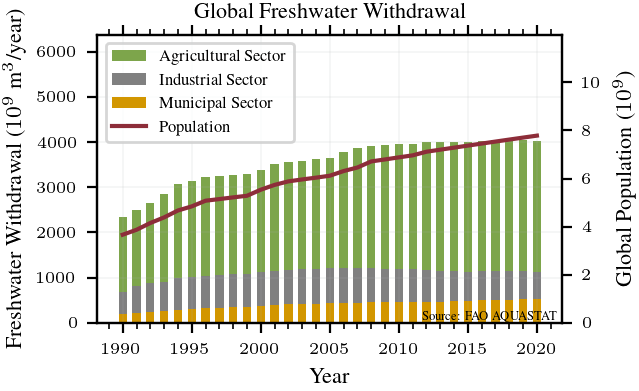

In [3]:
# define time interval (first year where data is considered)
TARGET_YEAR = 1990

# three types of water withdrawal: agricultural, industrial and municipal water withdrawal

'''relevant variables for us'''
RELEVANT_VARS = ['Total water withdrawal', 'Municipal water withdrawal', 'Industrial water withdrawal',
                 'Agricultural water withdrawal', 'Total population']
'''filter countries (no filter if empty)'''
FILTER_COUNTRIES = []

data = df[['Country', 'Year', *RELEVANT_VARS]]
if FILTER_COUNTRIES:
    data = data[data['Country'].isin(FILTER_COUNTRIES)]
data = data.dropna()

years = df['Year'].unique()
years = years[years >= TARGET_YEAR]

years_np_arr = np.zeros(years.shape[0])
water = np.zeros((years.shape[0], len(RELEVANT_VARS)))
population = np.zeros(years.shape[0])

for i, year in enumerate(years):
    # filter dataframe w.r.t. year 
    years_np_arr[i] = year
    df_filtered = data[data["Year"] == year]
    for j, var in enumerate(RELEVANT_VARS):
        if var != 'Total population':
            water[i, j] = df_filtered[var].sum()
        else:
            population[i] = df_filtered[var].sum()

import logging

logging.getLogger('matplotlib.font_manager').disabled = True

#plt.rcParams.update(bundles.icml2022())
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Global Freshwater Withdrawal')

# Grid
ax.grid(True, which='major', color=rgb.tue_gray, alpha=0.8, linewidth=0.1)

# X-axis
ax.set_xlabel('Year')
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.set_ylabel("Freshwater Withdrawal ($10^9$ m$^3$/year)")

width = 0.6
# ax.bar(years_np_arr - width / 2, water[:,0], width, color = rgb.tue_blue)
ax.bar(years_np_arr, water[:, 3], bottom=water[:, 1] + water[:, 2], width=width, color=rgb.tue_green,
       label='Agricultural Sector')
ax.bar(years_np_arr, water[:, 2], bottom=water[:, 1], width=width, color='grey',
       label='Industrial Sector')
ax.bar(years_np_arr, water[:, 1], width=width, color=rgb.tue_orange, label='Municipal Sector')

# plot population on second y-axis
ax2 = ax.twinx()
ax2.plot(years_np_arr, population * 1000 / 10 ** 9, color=rgb.tue_red, label='Population')

# set axis scaling
ax2.set_ylim(0, 1.5 * ax2.get_ylim()[1])
ax.set_ylim(0, 1.5 * ax.get_ylim()[1])

ax2.set_ylabel("Global Population ($10^9$)")

# Add source
ax.text(0.99, 0.01, 'Source: FAO AQUASTAT', fontsize='xx-small', transform=ax.transAxes, ha='right', color=(0, 0, 0))

# plot legends in one window
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

if save_figs:
    plt.savefig('../doc/water/fig/fig_population/global_water_withdrawal.pdf')

One can clearly see, that there appears to be a connection between both variables. While the global population grew from roughly 4 to 8 billion people, the total freshwater withdrawal also almost doubled.

Furthermore it is interesting to observe that a vast majority of the withdrawn water is used for agricultural purposes. Given the direct dependence of food production on population size, and considering that a substantial proportion of water withdrawal is attributed to agricultural activities, the correlation between freshwater withdrawal and population size appears evident.

Refer to exp_agricultural_water_usage.ipynb for further analysis regarding agricultural water usage.

As a next step we compute the correlation between both variables and conduct a permutation test to further explore the influence of the population variable on the total water withdrawal.

In [ ]:
# filter latest data for the year 2020
filt_df = df[df['Year'] == 2020]
# select relevant variables
filt_df = filt_df[['Country', 'Total population', "Total water withdrawal"]]
# drop all rows where no data is available (where NaNs occur)
filt_df = filt_df.dropna()
filt_df.head()

Calculate Correlation between Total Water Withdrawal and Population

In [ ]:
corr = filt_df['Total population'].corr(filt_df['Total water withdrawal'])
print(corr)

The high correlation suggests that there is an important relation between The population of a country and its total water withdrawal.

To further explore the coherence between the two variables a simple permutation test is constructed.

In [ ]:
# transform dataframe to np array and remove country column
data_arr = filt_df.to_numpy()[:, 1:]

# find median of population to split the countries in two categories
median = np.median(data_arr[:, 0])

# reshuffle population count for permutation test
rng = np.random.default_rng(1)  # random number generator

B = 100000  # number of permuations to produce

# repeat Y (one row) B times, shape now = (B, N), then shuffle the columns
X = data_arr[:, 0]  # X is set to population count which is permuted
Y = data_arr[:, 1]  # Y is set to total water withdrawal
X_permuted = rng.permuted(np.tile(X, (B, 1)), axis=1)


def T_mean(X):
    # create mask based on whether permuted label is over or under median
    group = np.where(X < median, True, False)

    # compute difference in means
    return np.mean(Y[group]) - np.mean(Y[~group])


# compute mean difference for original data
mean_true = T_mean(X)

# compute mean difference for permuted data
mean_dist = np.apply_along_axis(T_mean, 1, X_permuted)


The Null Hypothesis ($H_0$) is defines as: "The variable *population* has no effect on the *total water withdrawal*"

For this permutation test we seperate the countries in two groups depending on their respective population. The selection criteria is the median population.
Then the population lables are permuted.

$$
    Y_i = \left\{\begin{array}{ll}
        G_1 & X_i > median \\
        G_2 & X_i \leq median \\
    \end{array}
    \right. 
$$

To compare the obtained results for both groups we apply the following metric:

$$
    T = \left[ \frac{1}{n} \cdot \sum_{i \in G_1} Y_i \right] - \left[ \frac{1}{n} \cdot \sum_{i \in G_2} Y_i \right] 
$$
where $Y_i$ is a total water withdrawal sample of $G_1$ or $G_2$ respectively.

In [ ]:
plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

bins = np.linspace(-50, 50, 100)
ax.set_title('Total Water Withdrawal: Mean Difference')
ax.hist(mean_dist, bins=bins, density=True, label='$p_{H_0}(T)$', alpha=0.5, color=rgb.tue_dark)
ax.axvline(mean_true, label='$T(X)$', alpha=1.0, color=rgb.tue_red)
ax.legend(loc='upper right', frameon=False)
#ax.yaxis.set_visible(False)
ax.set_xlabel('$T$')

if save_figs:
    plt.savefig(to_fig_path('fig_population/fig_population/permutation_test.pdf'))

When performing the test with $n = 100,000$ different permutations, the ditribution shown in the figure above is obtained. As one can see the histogram obtained when assuming the Null Hypothesis is true does not contain the actual observation $T(X)$. This means the $p$-value must be smaller than $1 \cdot 10^{-5}$. Hence, we can reject the null hypothesis.

In [ ]:
bins = np.linspace(-50, 50, 101)
loc_data = np.argmax(bins >= mean_true)
histogram, _ = np.histogram(mean_dist, bins=bins, density=True)
empirical_cdf = (np.cumsum(histogram) / np.sum(histogram))

p_value = empirical_cdf[loc_data]

fig, ax = plt.subplots()
ax.plot(bins[:-1], empirical_cdf, label='empirical CDF', color=rgb.tue_dark)
ax.set_yscale('log')
ax.axvline(mean_true, label='data', alpha=1.0, color=rgb.tue_red)
ax.plot([-30, mean_true], [p_value, p_value], color=rgb.tue_gray, linestyle='-', marker="o", ms=2, lw=0.6)
ax.set_xlim(-50, 50)

#ax.text(-20, 0.0001, f'$p$-value = {p_value:.1e}', fontsize=8)
ax.set_xlabel(r'$T(X) = \bar{y}_{G_1} - \bar{y}_{G_2}$')
ax.set_ylabel('approx. CDF of permutation distribution')

if save_figs:
    plt.savefig(to_fig_path('fig_population/fig_permutation_test_2.fig'))